In [1]:
# standard python utilities
import os
import sys
from os.path import basename, dirname, join, exists
import glob
import pandas as pd
import numpy as np
import time
from scipy.stats import gmean


# standard geospatial python utilities
# import pyproj # for converting proj4string
import shapely
import shapefile
import geopandas as gpd
from osgeo import gdal
import rasterio

# import flopy

import matplotlib.pyplot as plt


In [2]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
# dir of all gwfm data
gwfm_dir = os.path.dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'

sfr_dir = gwfm_dir+'/SFR_data/'

In [339]:
out_dir = join(proj_dir, 'output')

In [3]:
flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)
    
import flopy 

In [228]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'
if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 
loadpth +=  '/GWFlowModel/Cosumnes/Stream_seepage'

model_nam = 'inset_oneto_denier'
model_nam = 'oneto_denier_2014_2018'

base_model_ws = join(loadpth,model_nam)

all_model_ws = join(loadpth, 'parallel_oneto_denier')
all_model_ws = join(loadpth, 'parallel_oneto_denier_2014_2018')

# may want to skip loading rch, evt and wel which take up a lot of memory with stress period data
load_only = ['DIS','UPW','SFR','OC']
m = flopy.modflow.Modflow.load('MF.nam', model_ws= base_model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt')


In [229]:
m_ver = ''

In [231]:
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, 'inset_oneto_denier','rm_only_grid.shp')
grid_p = gpd.read_file(grid_fn)
grid_p.crs='epsg:32610'
m_domain = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_p.unary_union], crs=grid_p.crs)

In [655]:
XSg = pd.read_csv(join(model_ws,'04_XSg_filled.csv'))
XSg = gpd.GeoDataFrame(XSg, geometry = gpd.points_from_xy(XSg.Easting, XSg.Northing), crs='epsg:32610')

drop_iseg = XSg[~XSg['Logger Location'].isna()].iseg.values
# overwrite SFR segment/reach input relevant to seepage
# sensor_dict = pd.read_csv(join(model_ws, 'sensor_xs_dict.csv'), index_col=0)
# XS_params = sensor_dict.join(params.set_index('Sensor'), on='Sensor')

In [656]:
sfrdf = pd.DataFrame(m.sfr.reach_data)
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index(drop=True)
grid_sfr = pd.concat((grid_sfr,sfrdf),axis=1)

# characterize streambed into different hydrofacies
tprogs_quants = np.array([0.590, 0.155, 0.197, 0.058]).cumsum()
vka_quants = grid_sfr.strhc1.quantile(tprogs_quants)
vka_quants.index=['mud','sandy mud','sand','gravel']
grid_sfr['facies'] = 'mud'
for n in np.arange(0,len(vka_quants)-1):
    grid_sfr.loc[grid_sfr.strhc1 > vka_quants.iloc[n],'facies'] = vka_quants.index[n+1]

# add color for facies plots
gel_color = pd.read_csv(join(gwfm_dir,'UPW_data', 'mf_geology_color_dict.csv'), comment='#')
gel_color.geology = gel_color.geology.str.lower()
grid_sfr = grid_sfr.join(gel_color.set_index('geology')[['color']], on='facies')
# remove stream segments for routing purposes only
grid_sfr = grid_sfr[~grid_sfr.iseg.isin(drop_iseg)]

In [446]:
strt_date = pd.to_datetime(m.dis.start_datetime)
end_date = (strt_date + pd.Series(m.dis.perlen.array.sum()).astype('timedelta64[D]'))[0]
# with SS period near 0 no longer minus one
dates_per = strt_date + (m.dis.perlen.array.cumsum()).astype('timedelta64[D]')
stplen = m.dis.perlen.array/m.dis.nstp.array
# astype timedelta64 results in save days
hrs_from_strt = ((np.append([0], np.repeat(stplen, m.dis.nstp.array)[:-1])).cumsum()*24).astype('timedelta64[h]')
dates_stps = strt_date + hrs_from_strt

# get ALL stress periods and time steps list, not just those in the output
kstpkper = []
for n,stps in enumerate(m.dis.nstp.array):
    kstpkper += list(zip(np.arange(0,stps),np.full(stps,n)))

dt_ref = pd.DataFrame(dates_stps, columns=['dt'])
dt_ref['kstpkper'] = kstpkper

# Obs checking

In [234]:
from sklearn.metrics import r2_score, mean_squared_error
def nse(targets,predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(predictions))**2))

# hob metadata
rm_grid = pd.read_csv(join(proj_dir, 'mw_hob_cleaned.csv'))


In [235]:
def clean_hob(model_ws):
    hobout = pd.read_csv(join(model_ws,'MF.hob.out'),delimiter=r'\s+', header = 0,names = ['sim_val','obs_val','obs_nam'],
                         dtype = {'sim_val':float,'obs_val':float,'obs_nam':object})
    hobout[['Sensor', 'spd']] = hobout.obs_nam.str.split('p',n=2, expand=True)
    hobout['kstpkper'] = list(zip(np.full(len(hobout),0), hobout.spd.astype(int)))
    hobout = hobout.join(dt_ref.set_index('kstpkper'), on='kstpkper')
    hobout['error'] = hobout.obs_val - hobout.sim_val
    hobout['sq_error'] = hobout.error**2
    return(hobout)

In [285]:
# 
sum_stats = pd.DataFrame(columns=['r2','RMSE','NSE'], dtype=np.float64)
mw_stats = pd.DataFrame(columns=['realization','SOSE','RMSE','NSE'], dtype=np.float64)
for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    hobout = clean_hob(model_ws)
    # summary stats by well
    mw_stats['realization'] = t
    for s in hobout.Sensor.unique():
        df_s = hobout[hobout.Sensor==s]
        mw_stats.loc[s,'SOSE'] = hobout[['Sensor','sq_error']].groupby('Sensor').sum()
        mw_stats.loc[s,'r2'] = r2_score(df_s.obs_val, df_s.sim_val)
        mw_stats.loc[s,'RMSE'] = mean_squared_error(df_s.obs_val, df_s.sim_val, squared=True)
        mw_stats.loc[s,'NSE'] = nse(df_s.obs_val, df_s.sim_val)

    # summary statistics
    sum_stats.loc[t,'r2'] = r2_score(hobout.obs_val, hobout.sim_val)
    sum_stats.loc[t,'RMSE'] = np.sqrt(hobout.sq_error.sum()/len(hobout))
    sum_stats.loc[t,'NSE'] = nse(hobout.obs_val, hobout.sim_val)


In [286]:
# filter out realizations who haven't finished running yet
stats_done = sum_stats[sum_stats.NSE!=sum_stats.NSE.min()]

<AxesSubplot: >

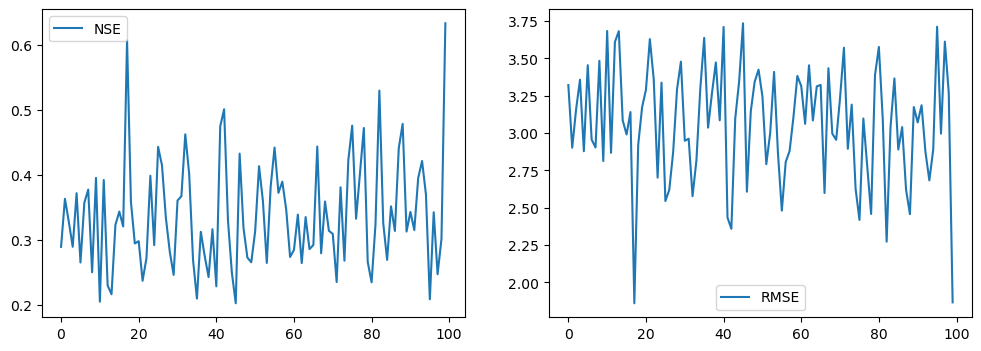

In [287]:
# review to see if error is generally similar between realizations
# review hydrographs for realization with worst error
fig,ax = plt.subplots(1,2, figsize=(12,4))
stats_done.plot(y='NSE', ax=ax[0])
stats_done.plot(y='RMSE', ax=ax[1])


In [334]:
# identify the 10 realizations with the best accuracy
# NSE and RMSE provide same result
nse_best = stats_done[(stats_done.NSE >= stats_done.NSE.quantile([0.9]).values[0])]
rmse_best = stats_done[(stats_done.RMSE <= stats_done.RMSE.quantile([0.1]).values[0])]
if len(nse_best.index) - nse_best.index.isin(rmse_best.index).sum()>0:
    print("NSE and RMSE don't agree, tie-break with r2")
    # where they don't agree use R2 for tie-break
    mismatch = ~nse_best.index.isin(rmse_best.index)
    nse_better = nse_best[mismatch].r2.values > rmse_best[mismatch].r2.values
    r2_best = pd.concat((nse_best[mismatch][nse_better], rmse_best[mismatch][~nse_better]))
    best_cln = pd.concat((nse_best[~mismatch], r2_best))    
    print(best_cln.index)
    best_cln.to_csv(join(proj_dir,'top_10_accurate_realizations.csv'))
else:
    print("NSE and RMSE agree")
    print(nse_best.index)
    nse_best.to_csv(join(proj_dir,'top_10_accurate_realizations.csv'))

NSE and RMSE don't agree, tie-break with r2
Int64Index([17, 41, 42, 75, 78, 82, 88, 99, 25, 55], dtype='int64')


In [607]:
# check hydrographs with worst error
t = sum_stats['RMSE'].idxmax()
# t = sum_stats['RMSE'].idxmin()
# approximate median location
t = sum_stats[1:][(sum_stats[1:].NSE == sum_stats[1:].NSE.median())].index[0]

# t = 45
print(t)
hobout = clean_hob(join(all_model_ws, 'realization'+ str(t).zfill(3)))
hob_long = hobout.melt(id_vars=['dt', 'Sensor'],value_vars=['sim_val','obs_val'], value_name='gwe')
# hob_long

81


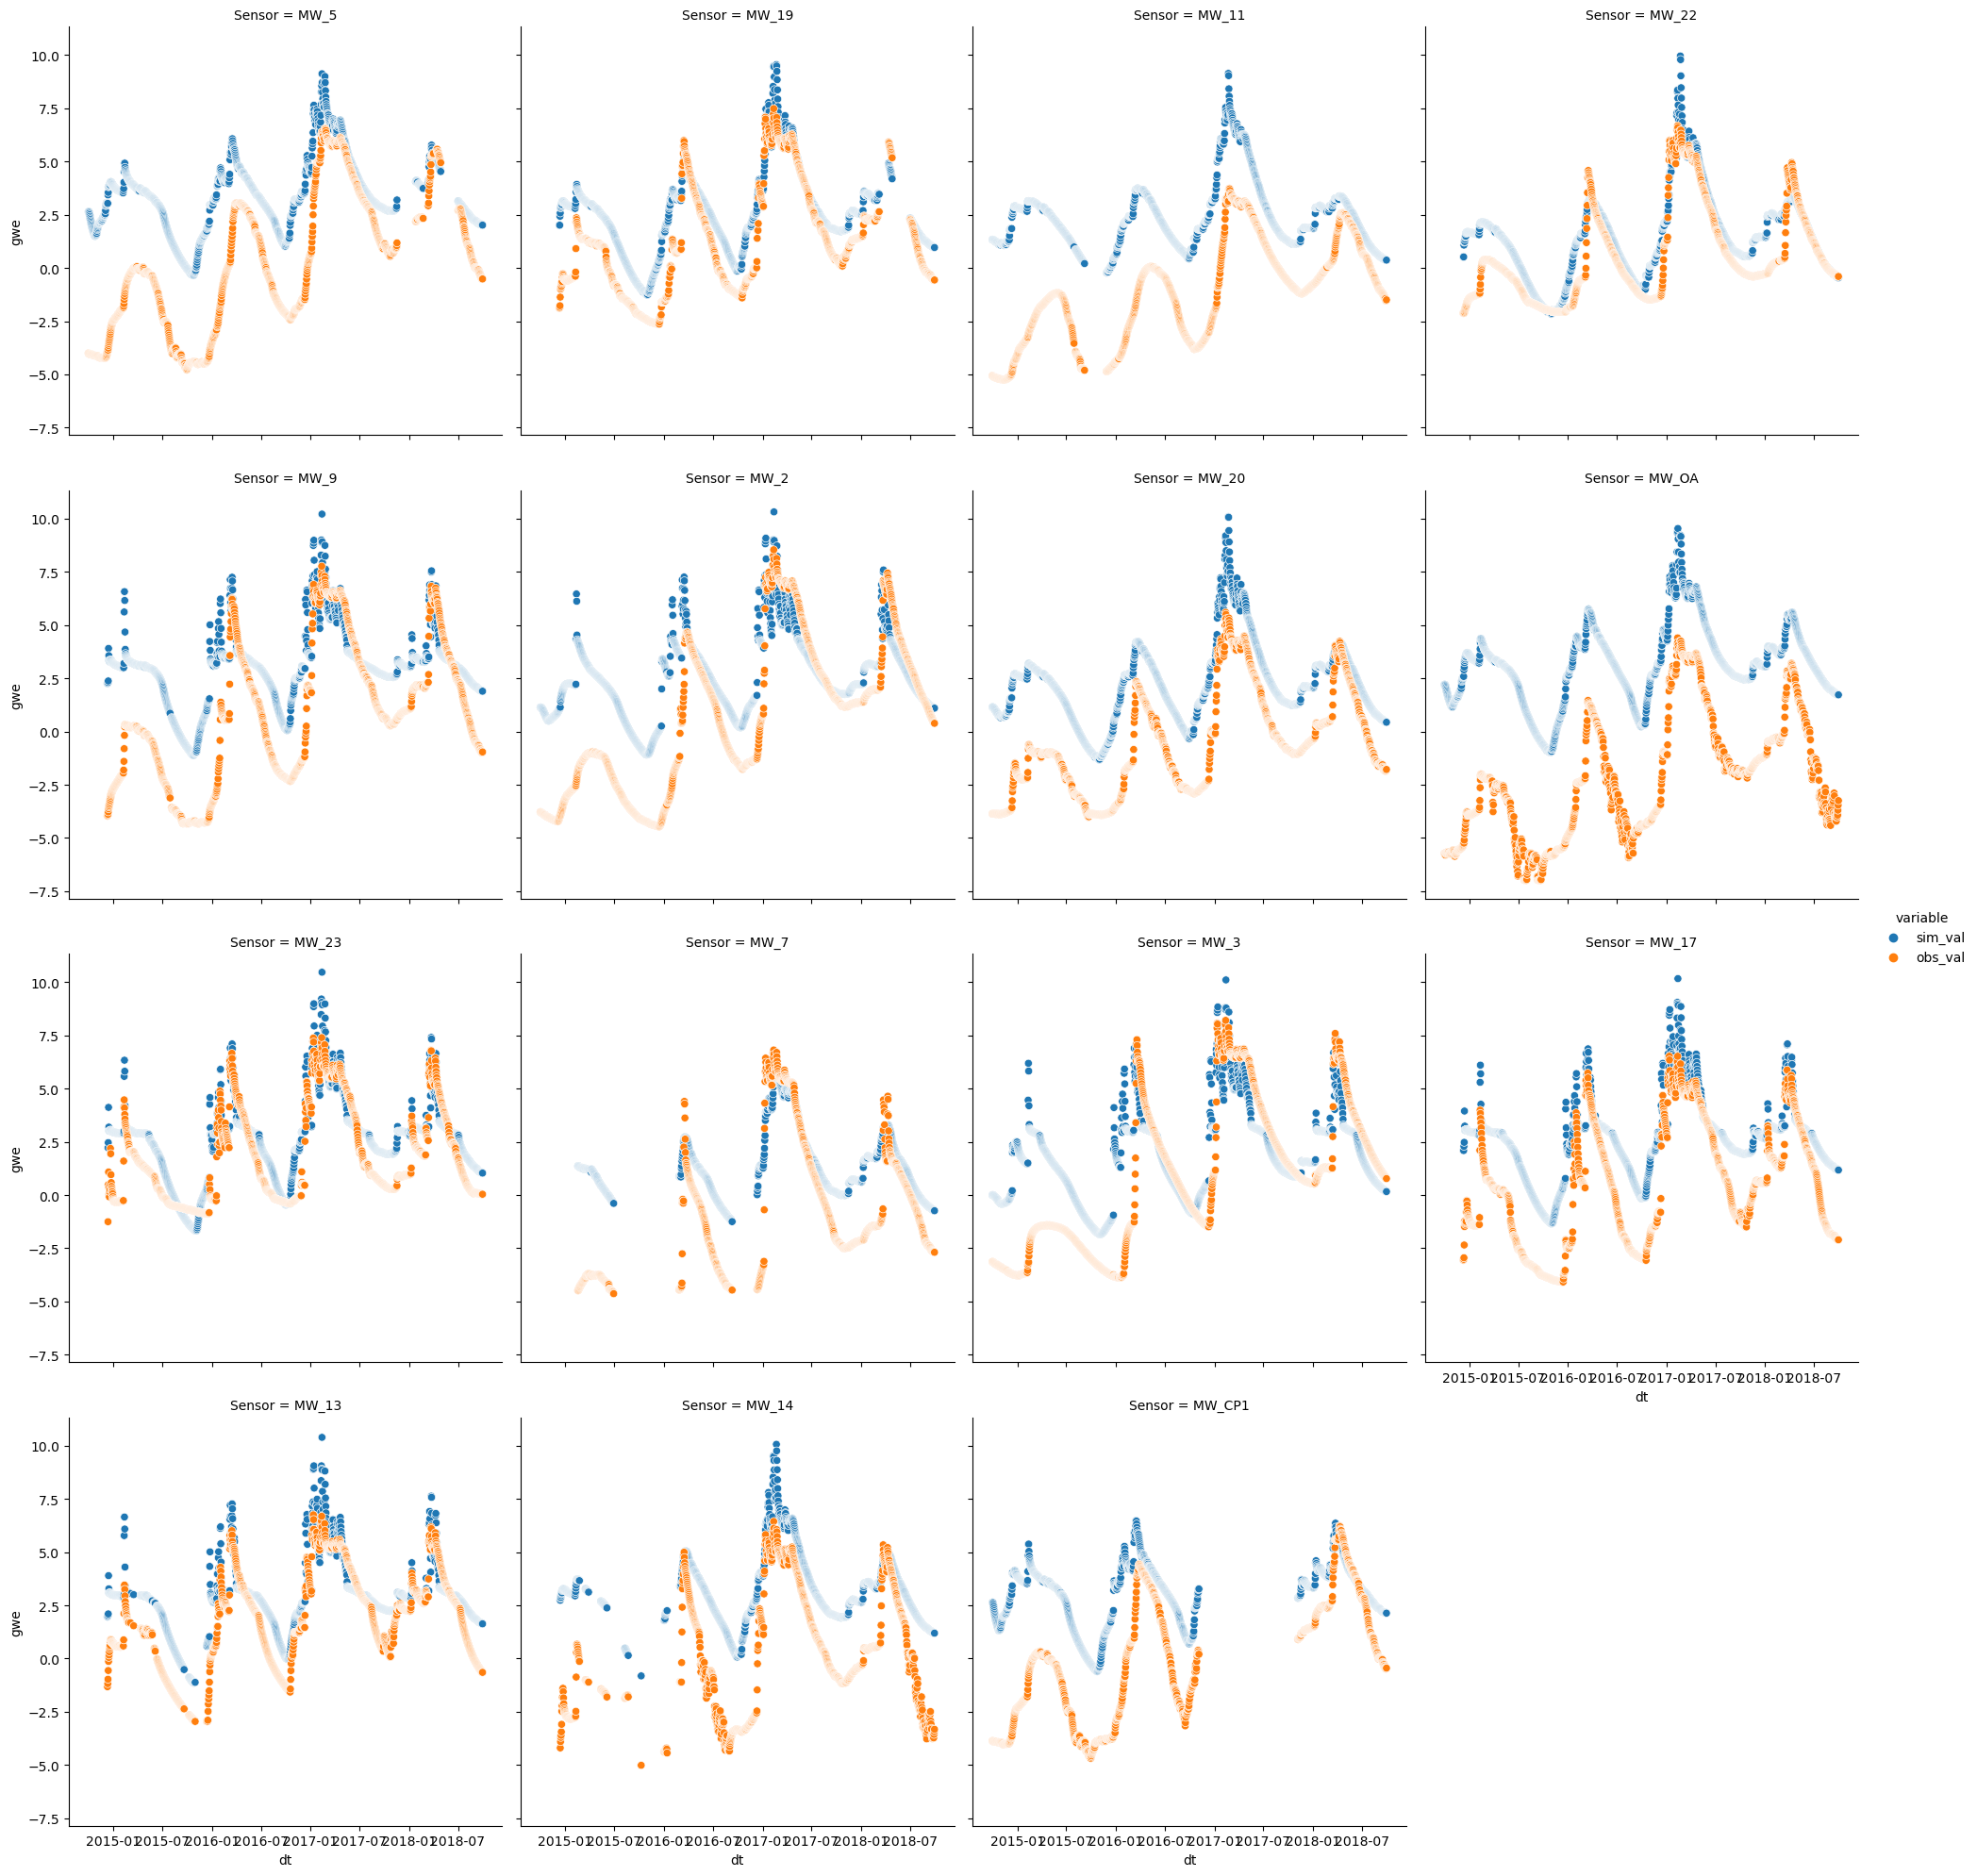

In [608]:
# in the wrost case the dynamics match but the magnitude is off (levels start much too low)
import seaborn as sns
g = sns.relplot(hob_long, x='dt',y='gwe',col='Sensor',hue='variable', col_wrap=4)



In [693]:
gage_cols = ['time','stage','volume','conc','inflows','outflows','conductance','error']

def read_gage(gagenam):
    gage = pd.read_csv(gagenam,skiprows=1, delimiter = r'\s+', engine='python')
    cols = gage.columns[1:-1]
    gage = gage.dropna(axis=1)
    gage.columns = cols
    strt_date = pd.to_datetime(m.dis.start_datetime)
    gage['dt'] = strt_date+(gage.Time*24).astype('timedelta64[h]')
    gage = gage.set_index('dt')
    gage['dVolume'] = gage.Volume.diff()
    gage['Total_In'] = gage[['Precip.','Runoff','GW-Inflw','SW-Inflw']].sum(axis=1)
    gage['Total_Out'] = gage[['Evap.','Withdrawal','GW-Outflw','SW-Outflw']].sum(axis=1)
    gage['In-Out'] = gage.Total_In - gage.Total_Out
#     gage['name'] = run
    return(gage)


# Stream seepage plots

In [703]:
pd_sfr = grid_sfr.set_index(['iseg','ireach'])[['rchlen','strtop', 'facies', 'color']]
pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()

def clean_sfr_df(model_ws, drop_iseg):
    ## load sfr reach data ##
    grid_sfr = pd.read_csv(model_ws+'/grid_sfr.csv')
    # remove stream segments for routing purposes only
    grid_sfr = grid_sfr[~grid_sfr.iseg.isin(drop_iseg)]
    pd_sfr = grid_sfr.set_index(['iseg','ireach'])[['rchlen','strtop', 'facies', 'color']]
    pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()
    num_coarse = int(grid_sfr.facies.isin(['gravel','sand']).sum())
    ## load sfr out file ##
    sfrout = flopy.utils.SfrFile(join(model_ws, m.name+m_ver+'.sfr.out'))
    sfrdf = sfrout.get_dataframe()
    sfrdf = sfrdf.join(dt_ref.set_index('kstpkper'), on='kstpkper').set_index('dt')
    # convert from sub-daily to daily using mean, lose kstpkper
    sfrdf = sfrdf.groupby('segment').resample('D').mean(numeric_only=True)
    sfrdf = sfrdf.reset_index('segment', drop=True)
    sfrdf[['row','column']] = sfrdf[['row','column']].astype(int) - 1 # convert to python
    ## join sfr out to reach data ##
    sfrdf = sfrdf.join(pd_sfr ,on=['segment','reach'],how='inner',lsuffix='_all')
        
    ## data transformation for easier manipulation ##
    cmd2cfs = 1/((0.3048**3)*86400) # cubic meters per day to cfs
    sfrdf['month'] = sfrdf.index.month
    sfrdf['WY'] = sfrdf.index.year
    sfrdf.loc[sfrdf.month>=10, 'WY'] +=1
    # create column to calculate days flowing
    sfrdf['flowing'] = 1
    sfrdf.loc[sfrdf.Qout <= 0, 'flowing'] = 0
    # dependent on number of time steps
    sfrdf['Qin_cfs'] = sfrdf.Qin * cmd2cfs
    sfrdf['Qout_cfs'] = sfrdf.Qout * cmd2cfs
    sfrdf['Qaquifer_cfs'] = sfrdf.Qaquifer * cmd2cfs
    
    # create different column for stream losing vs gaining seeapge
    sfrdf['Qrech'] = np.where(sfrdf.Qaquifer>0, sfrdf.Qaquifer,0)
    sfrdf['Qbase'] = np.where(sfrdf.Qaquifer<0, sfrdf.Qaquifer*-1,0 )
    # booleans for plotting
    sfrdf['gaining'] = (sfrdf.gradient == 0)
    sfrdf['losing'] = (sfrdf.gradient >= 0)
    sfrdf['connected'] = (sfrdf.gradient < 1)
    return(sfrdf)



In [706]:
sfrdf =  clean_sfr_df(base_model_ws, drop_iseg)
# sfrdf = sfrdf.join(pd_sfr ,on=['segment','reach'],how='inner',lsuffix='_all')


# Aggregate stream data
1. Aggregate across all segments  but save all dates
2. Aggregate across dates but save all segments


## Gradient plots (spatial)
1. Seepage averaged across the year (or between dry and wet season) and the rows could be realizations instead which would help indicate consistency across realizations  
2. Heat map of columns with stream segments, rows of dates and the color blue to red for gaining or losing with the seepage averaged across all realizations

When the gradient is greater than 1 we know we have disconnected conditions, I need to represent the count of days where the system is connected.

In [709]:
# aggregate data by facies and sum to review seepage over time
t0 = time.time()

sfr_facies_all = pd.DataFrame()
for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
#     grid_sfr = pd.read_csv(model_ws+'/grid_sfr.csv')
    # remove stream segments for routing purposes only
#     grid_sfr = grid_sfr[~grid_sfr.iseg.isin(drop_iseg)]
#     pd_sfr = grid_sfr.set_index(['iseg','ireach'])[['rchlen','strtop', 'facies', 'color']]
#     pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()

    sfrdf =  clean_sfr_df(model_ws, drop_iseg)
#     sfrdf = sfrdf.join(pd_sfr ,on=['segment','reach'],how='inner',lsuffix='_all')

    sfr_facies_sum = sfrdf.groupby(['dt','facies']).sum(numeric_only=True)
    sfr_facies_sum['realization'] = t
    # count number of facies if needed later for explaining rates
    sfr_facies_sum['num_facies'] = sfrdf.groupby(['dt','facies']).count().iloc[:,0].values
    sfr_facies_all = pd.concat((sfr_facies_all, sfr_facies_sum))
# check time
t1 = time.time()
print('Time: %.2f min' % ((t1-t0)/60))
# save output to speed up reuse
# sfr_facies_all.to_csv(join(out_dir, 'sfrdf_facies_sum.csv'))
# sfr_facies_all.reset_index(level='facies').to_hdf(join(out_dir, 'sfrdf_facies_sum.hdf5'), key='dt', complevel=4)

Time: 0.68 min


In [713]:
sfr_facies_all = pd.read_hdf(join(out_dir, 'sfrdf_facies_sum.hdf5'))
sfr_facies_all = sfr_facies_all.set_index('facies', append=True)

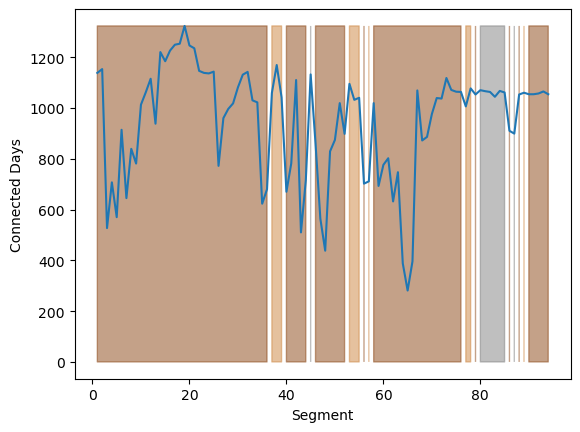

In [335]:
# fig,ax = plt.subplots()

# days connected
df_plt = sfrdf.groupby('segment').sum(numeric_only=True)[['connected']]
ax_conn = df_plt.plot(legend=False)
plt.ylabel('Connected Days')
plt.xlabel('Segment')

for f in sfrdf.facies.unique():
    ax_conn.fill_between(sfrdf.segment, 0, df_plt.max(), where = sfrdf.facies==f,
                    color=gel_color.loc[gel_color.geology==f,'color'], alpha=0.5)

In [609]:
# value of heat map vs line plot
# sfr_facies.groupby('segment').sum()['Qaquifer'].plot()
# sfrdf.groupby('segment').mean(numeric_only=True)['gradient'].plot()

## Notes
In these I need to clarify the proportion of the streambed (length or area) that is each facies to show that despite being only a small percent of the streambed sand and gravel make up a significant portion of recharge and baseflow. 

## Seepage plots (temporal)
Aggregate by facies to plot cumulative seepage (by time) to help show variability caused by geology.

In [ ]:
for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    
    sfrdf =  clean_sfr_df(model_ws, drop_iseg)
    sfr_facies_sum = sfrdf.groupby(['dt','facies']).sum(numeric_only=True)

Time: 0.12 min


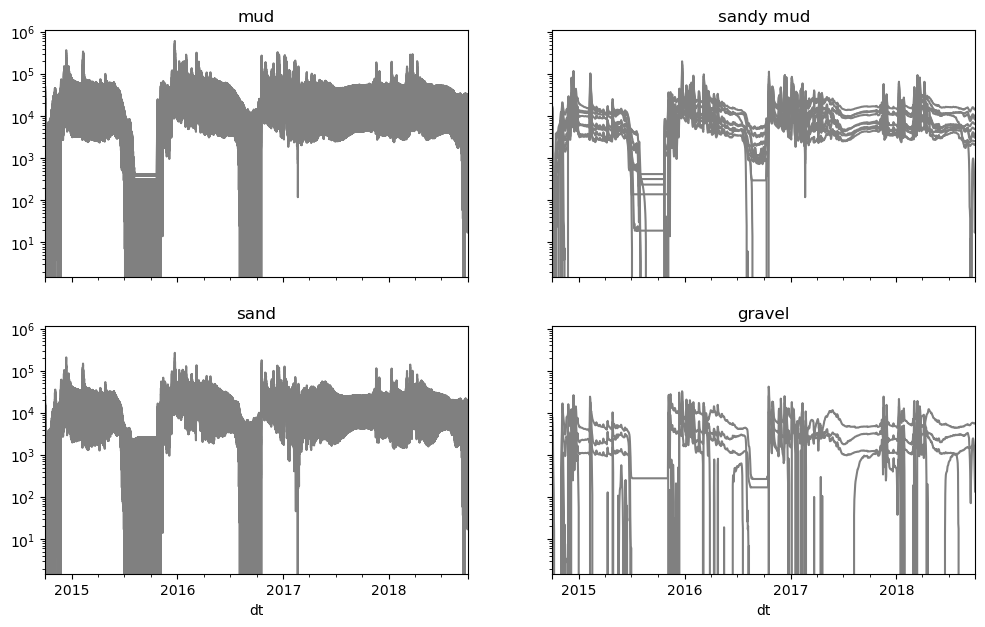

In [712]:
t0 = time.time()
fig,ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)#

for t in np.arange(0,100):    
    sfr_facies_sum = sfr_facies_all[sfr_facies_all.realization==t]
    sfr_facies_sum = sfr_facies_sum[['Qrech','Qbase']].melt(ignore_index=False)

    for n,f in enumerate(['mud','sandy mud','sand','gravel']):
        ax_n = ax[int(n/2), n%2]
        df_plt = sfr_facies_sum[sfr_facies_sum.variable=='Qrech'].filter(like=f, axis=0).reset_index('facies')
        if df_plt.shape[0]>0:
            df_plt.plot(y='value', ax=ax_n, legend=False, color='gray')
# set axis labels
for n,f in enumerate(['mud','sandy mud','sand','gravel']):
    ax_n = ax[int(n/2), n%2]
    ax_n.set_title(f)
    ax_n.set_yscale('log')
    
t1 = time.time()
print('Time: %.2f min' % ((t1-t0)/60))

Despite being only a small percentage of the stream segments, the sand and gravel produce a significant portion of the stream seepage.

Time: 0.07 min


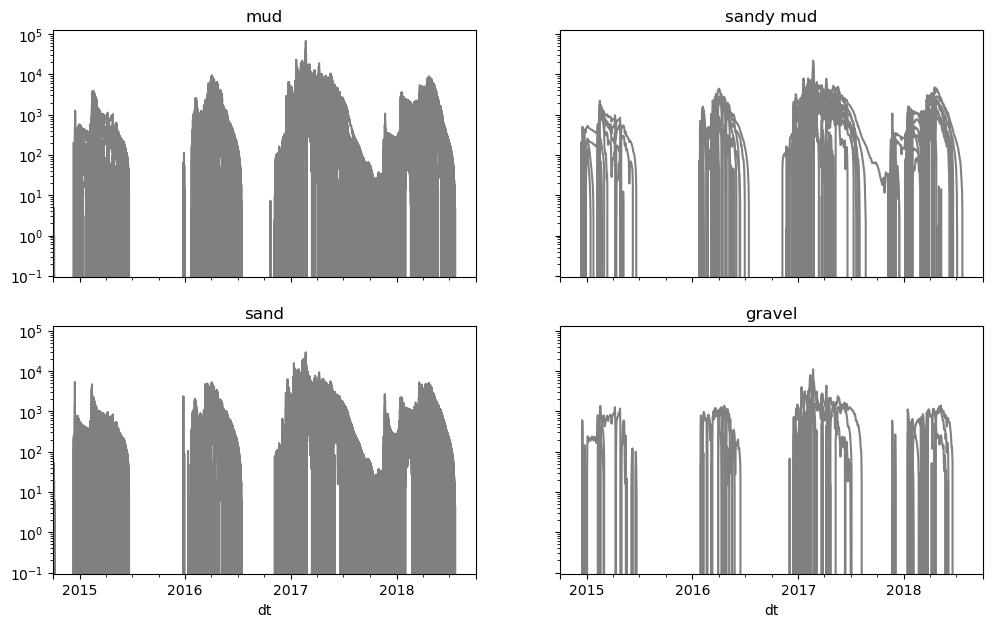

In [418]:
t0 = time.time()
fig,ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)#

for t in np.arange(0,100):
    sfr_facies_sum = sfr_facies_all[sfr_facies_all.realization==t]
    sfr_facies_sum = sfr_facies_sum[['Qrech','Qbase']].melt(ignore_index=False)

    for n,f in enumerate(['mud','sandy mud','sand','gravel']):
        ax_n = ax[int(n/2), n%2]
        df_plt = sfr_facies_sum[sfr_facies_sum.variable=='Qbase'].filter(like=f, axis=0).reset_index('facies')
        if df_plt.shape[0]>0:
            df_plt.plot(y='value', ax=ax_n, legend=False, color='gray')
# set axis labels
for n,f in enumerate(['mud','sandy mud','sand','gravel']):
    ax_n = ax[int(n/2), n%2]
    ax_n.set_title(f)
    ax_n.set_yscale('log')
    
t1 = time.time()
print('Time: %.2f min' % ((t1-t0)/60))

## Streamflow
No need to aggregate by facies, instead show impact at downstream end in terms of time step and cumulative

In [422]:
# sum seepage for each realization and date to provide summary graphic
sfr_sum = sfr_facies_all.groupby(['dt','realization']).sum()

Time: 6.20 min


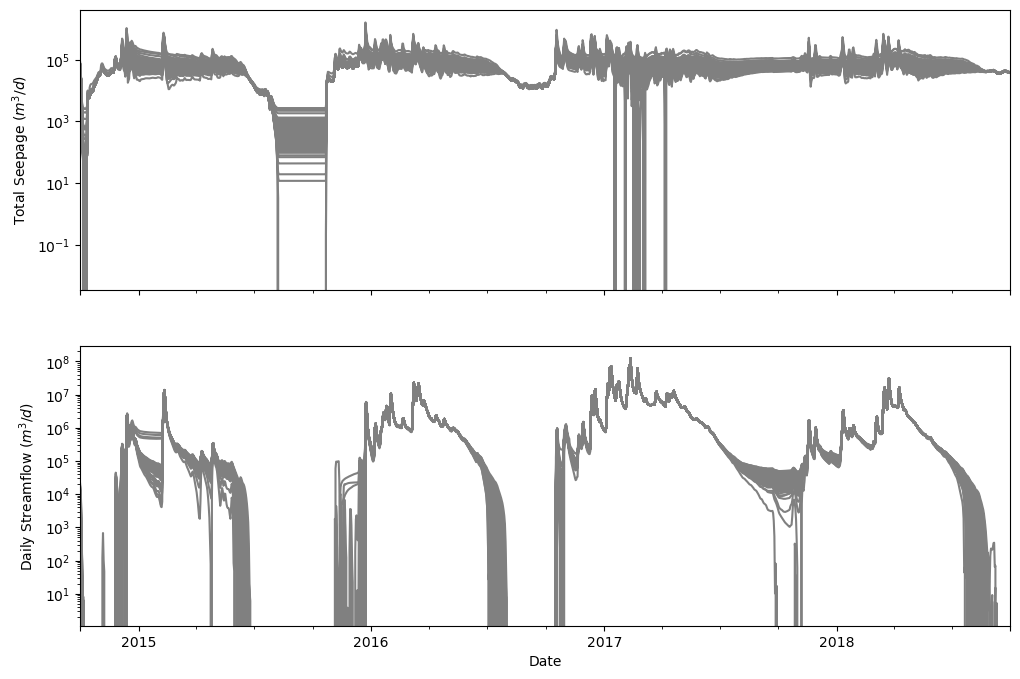

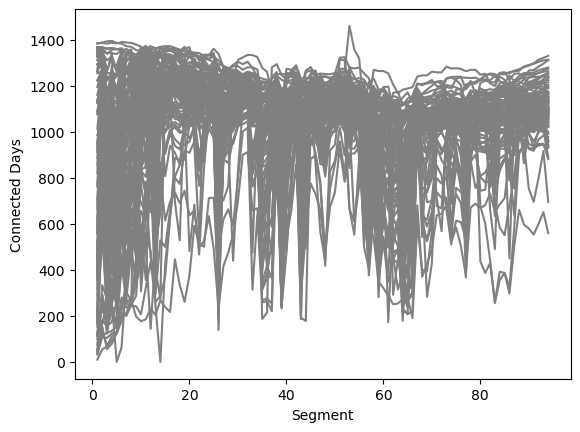

In [485]:
t0 = time.time()
fig,ax = plt.subplots(2,1, figsize=(12,8), sharex=True, sharey=False)
# plot of number of connected days across realizations
fig_conn, ax_conn = plt.subplots()
for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    
#     grid_sfr = pd.read_csv(model_ws+'/grid_sfr.csv')
#     # remove stream segments for routing purposes only
#     grid_sfr = grid_sfr[~grid_sfr.iseg.isin(drop_iseg)]
#     pd_sfr = grid_sfr.set_index(['iseg','ireach'])[['rchlen','strtop', 'facies', 'color']]
#     pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()

    sfrdf =  clean_sfr_df(model_ws, drop_iseg)
#     sfrdf = sfrdf.join(pd_sfr ,on=['segment','reach'],how='inner',lsuffix='_all')
    # plot from last segment (shows cumulative effects)
    sfr_last = sfrdf[sfrdf.segment==sfrdf.segment.max()]

    sfr_last.plot(y='Qin', ax=ax[1], legend=False, color='gray')
    ax[1].set_ylabel('Daily Streamflow ($m^3/d$)')
    ax[1].set_xlabel('Date')
    ax[1].set_yscale('log')

    sfrdf.groupby('dt').sum(numeric_only=True).plot(y='Qaquifer', ax=ax[0], legend=False, color='gray')
    ax[0].set_ylabel('Total Seepage ($m^3/d$)')
    # need log scale or peaks wash out other data
    ax[0].set_yscale('log')
    
    
    
    # plot the connected days
    df_plt = sfrdf.groupby('segment').sum(numeric_only=True)[['connected']]
    df_plt.plot(ax = ax_conn, legend=False, color='gray')
    ax_conn.set_ylabel('Connected Days')
    ax_conn.set_xlabel('Segment')
    
t1 = time.time()
print('Time: %.2f min' % ((t1-t0)/60))

In [638]:

# # groupby water year and segment to identify last day of flow for each segment and year
# # find minimum flow for each year and segment then identify when that occurs
# # sfr_min = sfrdf.groupby(['segment','WY']).min()
# # sfr_min[['Qin']]
# sn=1
# sfr_seg = sfrdf[sfrdf.segment==sn]
# yn = 2015
# sfr_seg_wy = sfr_seg[sfr_seg.WY==yn]
# # we are looking for the last date of flow in the summer
# sfr_seg_wy['Qchk'] = sfr_seg_wy
# sfr_seg_wy_min = sfr_seg_wy[sfr_seg_wy.Qout == sfr_seg_wy.Qout.min()]


In [665]:
sfrdf.groupby(['WY','segment']).sum(numeric_only=True)

layer    row  column  reach           Qin       Qaquifer  \
WY   segment                                                             
2015 1.0      730.0  11315   29930  365.0  8.357162e+07  483093.787814   
     2.0      730.0  11315   29565  365.0  8.309036e+07  467387.457200   
     3.0      730.0  11315   29200  365.0  8.262414e+07  336760.837700   
     4.0      730.0  11315   28835  365.0  8.228800e+07  335724.610600   
     5.0      730.0  11315   28470  365.0  8.195400e+07  227115.461000   
...             ...    ...     ...    ...           ...            ...   
2018 90.0     730.0  19710    2190  365.0  4.162711e+08  109084.648000   
     91.0     730.0  19710    1825  365.0  4.161609e+08  131534.742000   
     92.0     730.0  19710    1460  365.0  4.160326e+08  142306.386500   
     93.0     730.0  19710    1095  365.0  4.158901e+08  100918.414800   
     94.0     730.0  19710     730  365.0  4.157897e+08  226735.632000   

                      Qout  Qovr  Qprecip  Qet  ...       Qout_cfs  \
WY   segment                                    ...                  
2015 1.0      8.309036e+07   0.0      0.0  0.0  ...   33961.901830   
     2.0      8.262414e+07   0.0      0.0  0.0  ...   33771.340722   
     3.0      8.228800e+07   0.0      0.0  0.0  ...   33633.949501   
     4.0      8.195400e+07   0.0      0.0  0.0  ...   33497.431995   
     5.0      8.172799e+07   0.0      0.0  0.0  ...   33405.054389   
...                    ...   ...      ...  ...  ...            ...   
2018 90.0     4.161609e+08   0.0      0.0  0.0  ...  170099.365389   
     91.0     4.160326e+08   0.0      0.0  0.0  ...  170046.891963   
     92.0     4.158901e+08   0.0      0.0  0.0  ...  169988.666055   
     93.0     4.157897e+08   0.0      0.0  0.0  ...  169947.621973   
     94.0     4.155621e+08   0.0      0.0  0.0  ...  169854.584136   

              Qaquifer_cfs          Qrech      Qbase  gaining  losing  \
WY   segment                                                            
2015 1.0        197.457131  483093.787814     0.0000        0     365   
     2.0        191.037411  467387.457200     0.0000        0     365   
     3.0        137.645796  336760.837700     0.0000        0     365   
     4.0        137.222254  335724.610600     0.0000        0     365   
     5.0         92.829940  227115.461000     0.0000        0     365   
...                    ...            ...        ...      ...     ...   
2018 90.0        44.586667  109183.399000    98.7510        0     362   
     91.0        53.762796  131534.742000     0.0000        0     365   
     92.0        58.165539  142706.257000   399.8705        0     353   
     93.0        41.248845  109958.937800  9040.5230        0     315   
     94.0        92.674691  226735.632000     0.0000        0     365   

              connected   rchlen       strtop  Total distance (m)  
WY   segment                                                       
2015 1.0             97  36500.0  2543.673096             36500.0  
     2.0            190  36500.0  2474.891602             73000.0  
     3.0             58  36500.0  2406.109863            109500.0  
     4.0            136  36500.0  2337.328369            146000.0  
     5.0             82  36500.0  2268.546875            182500.0  
...                 ...      ...          ...                 ...  
2018 90.0           309  36500.0   -99.883247           3175500.0  
     91.0           307  36500.0  -119.524727           3212000.0  
     92.0           308  36500.0  -138.508240           3248500.0  
     93.0           308  36500.0  -155.623215           3285000.0  
     94.0           272  36500.0  -171.459961           3321500.0  

[364 rows x 32 columns]

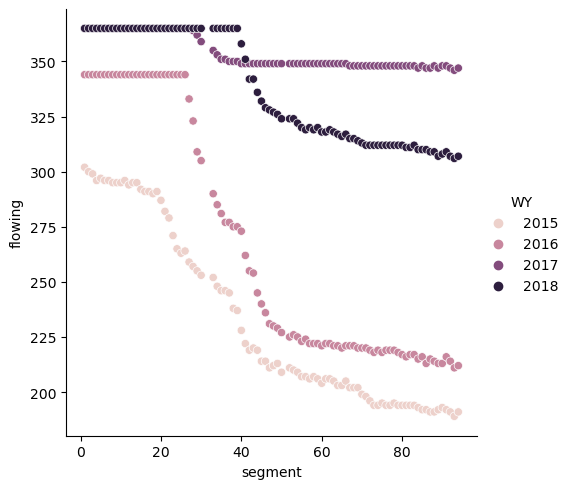

In [664]:
# find last day of flow

# start simple with just year by segment ,'month','facies'
sns.relplot(sfrdf.groupby(['WY','segment']).sum(numeric_only=True), x='segment',y='flowing', hue='WY')

## Scatter plots
**Goal**: relate the heterogeneity (e.g., number of coarse bodies connecting to the stream) to the number of days with streamflow.

Need to save data as an aggregated dataframe to run trend analysis

In [714]:
t0 = time.time()

sfrdf_all = pd.DataFrame()
sfr_yr_sum_all = pd.DataFrame()

for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    # count number of segments overlying sand/gravel
#     grid_sfr = pd.read_csv(model_ws+'/grid_sfr.csv')
#     # remove stream segments for routing purposes only
#     grid_sfr = grid_sfr[~grid_sfr.iseg.isin(drop_iseg)]
#     pd_sfr = grid_sfr.set_index(['iseg','ireach'])[['rchlen','strtop', 'facies', 'color']]
#     pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()
    num_coarse = int(grid_sfr.facies.isin(['gravel','sand']).sum())
    # clean sfr output
    sfrdf =  clean_sfr_df(model_ws, drop_iseg)
#     sfrdf = sfrdf.join(pd_sfr ,on=['segment','reach'],how='inner',lsuffix='_all')
    sfrdf['realization'] = t
    sfrdf['num_coarse'] = num_coarse
    # aggregate to seasonal values, since model starts in october it groups as oct-dec, jan-mar, apr-jun, jul-sep
    sfrdf_mon = sfrdf.resample('3MS').mean(numeric_only=True)
    sfrdf_mon['realization'] = t
    sfrdf_mon['num_coarse'] = num_coarse
    sfrdf_all = pd.concat((sfrdf_all, sfrdf_mon))
    # aggregate to annual values for each segment
    sfrdf_yr_sum = sfrdf.groupby(['WY','segment']).sum(numeric_only=True)
    sfrdf_yr_sum['realization'] = t
    sfrdf_yr_sum['num_coarse'] = num_coarse
    sfr_yr_sum_all = pd.concat((sfr_yr_sum_all, sfrdf_yr_sum))
# check time
t1 = time.time()
print('Time: %.2f min' % ((t1-t0)/60))

# save output to speed up reuse
sfrdf_all.to_csv(join(out_dir, 'sfrdf_3month_mean.csv'))
sfr_yr_sum_all.to_csv(join(out_dir, 'sfrdf_annual_sum_by_segment.csv'))

Time: 0.63 min


In [720]:
# save output to speed up reuse
sfrdf_all = pd.read_csv(join(out_dir, 'sfrdf_3month_mean.csv'))
sfr_yr_sum_all = pd.read_csv(join(out_dir, 'sfrdf_annual_sum_by_segment.csv'), index_col=['WY','segment'])

In [721]:
drop_iseg
sfr_yr_sum_all.loc[2015, 52][sfr_yr_sum_all.loc[2015, 52].flowing>340]

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_40436\2527568989.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  sfr_yr_sum_all.loc[2015, 52][sfr_yr_sum_all.loc[2015, 52].flowing>340]


layer    row  column  reach           Qin      Qaquifer  \
WY   segment                                                            
2015 52.0     730.0  16425   13870  365.0  8.843507e+07   55523.60200   
     52.0     730.0  16425   13870  365.0  8.504906e+07  112843.09600   
     52.0     730.0  16425   13870  365.0  8.619100e+07   80270.79000   
     52.0     730.0  16425   13870  365.0  8.705276e+07   99259.82500   
     52.0     730.0  16425   13870  365.0  8.358375e+07   49409.68848   
     52.0     730.0  16425   13870  365.0  8.337254e+07  232171.18200   
     52.0     730.0  16425   13870  365.0  8.266917e+07  177731.12000   
     52.0     730.0  16425   13870  365.0  8.607667e+07   72744.59100   
     52.0     730.0  16425   13870  365.0  8.272988e+07  122311.61600   
     52.0     730.0  16425   13870  365.0  8.577333e+07   53896.36000   
     52.0     730.0  16425   13870  365.0  8.202422e+07   66845.87700   
     52.0     730.0  16425   13870  365.0  8.293259e+07   99610.68400   
     52.0     730.0  16425   13870  365.0  8.597409e+07  166388.91600   

                      Qout  Qovr  Qprecip  Qet  ...        Qrech     Qbase  \
WY   segment                                    ...                          
2015 52.0     8.837993e+07   0.0      0.0  0.0  ...   55523.6020   0.00000   
     52.0     8.493680e+07   0.0      0.0  0.0  ...  112843.0960   0.00000   
     52.0     8.611087e+07   0.0      0.0  0.0  ...   80270.7900   0.00000   
     52.0     8.695429e+07   0.0      0.0  0.0  ...   99259.8250   0.00000   
     52.0     8.353513e+07   0.0      0.0  0.0  ...   49426.6116  16.92312   
     52.0     8.314094e+07   0.0      0.0  0.0  ...  232171.1820   0.00000   
     52.0     8.249154e+07   0.0      0.0  0.0  ...  177731.1200   0.00000   
     52.0     8.600499e+07   0.0      0.0  0.0  ...   72744.5910   0.00000   
     52.0     8.260756e+07   0.0      0.0  0.0  ...  122311.6160   0.00000   
     52.0     8.571966e+07   0.0      0.0  0.0  ...   53896.3600   0.00000   
     52.0     8.195787e+07   0.0      0.0  0.0  ...   66845.8770   0.00000   
     52.0     8.283343e+07   0.0      0.0  0.0  ...   99610.6840   0.00000   
     52.0     8.580853e+07   0.0      0.0  0.0  ...  166388.9160   0.00000   

              gaining  losing  connected   rchlen      strtop  \
WY   segment                                                    
2015 52.0           0     365        259  36500.0  1037.05698   
     52.0           0     365        200  36500.0  1037.05698   
     52.0           0     365        271  36500.0  1037.05698   
     52.0           0     365        234  36500.0  1037.05698   
     52.0           0     361        296  36500.0  1037.05698   
     52.0           0     365        189  36500.0  1037.05698   
     52.0           0     365        231  36500.0  1037.05698   
     52.0           0     365        216  36500.0  1037.05698   
     52.0           0     365        220  36500.0  1037.05698   
     52.0           0     365        240  36500.0  1037.05698   
     52.0           0     365        218  36500.0  1037.05698   
     52.0           0     365        265  36500.0  1037.05698   
     52.0           0     365        188  36500.0  1037.05698   

              Total distance (m)  realization  num_coarse  
WY   segment                                               
2015 52.0              1788500.0           10          45  
     52.0              1788500.0           11           7  
     52.0              1788500.0           12          29  
     52.0              1788500.0           22          39  
     52.0              1788500.0           40          53  
     52.0              1788500.0           42           5  
     52.0              1788500.0           44          36  
     52.0              1788500.0           46           9  
     52.0              1788500.0           49          30  
     52.0              1788500.0           53          35  
     52.0              1788500.0           64      

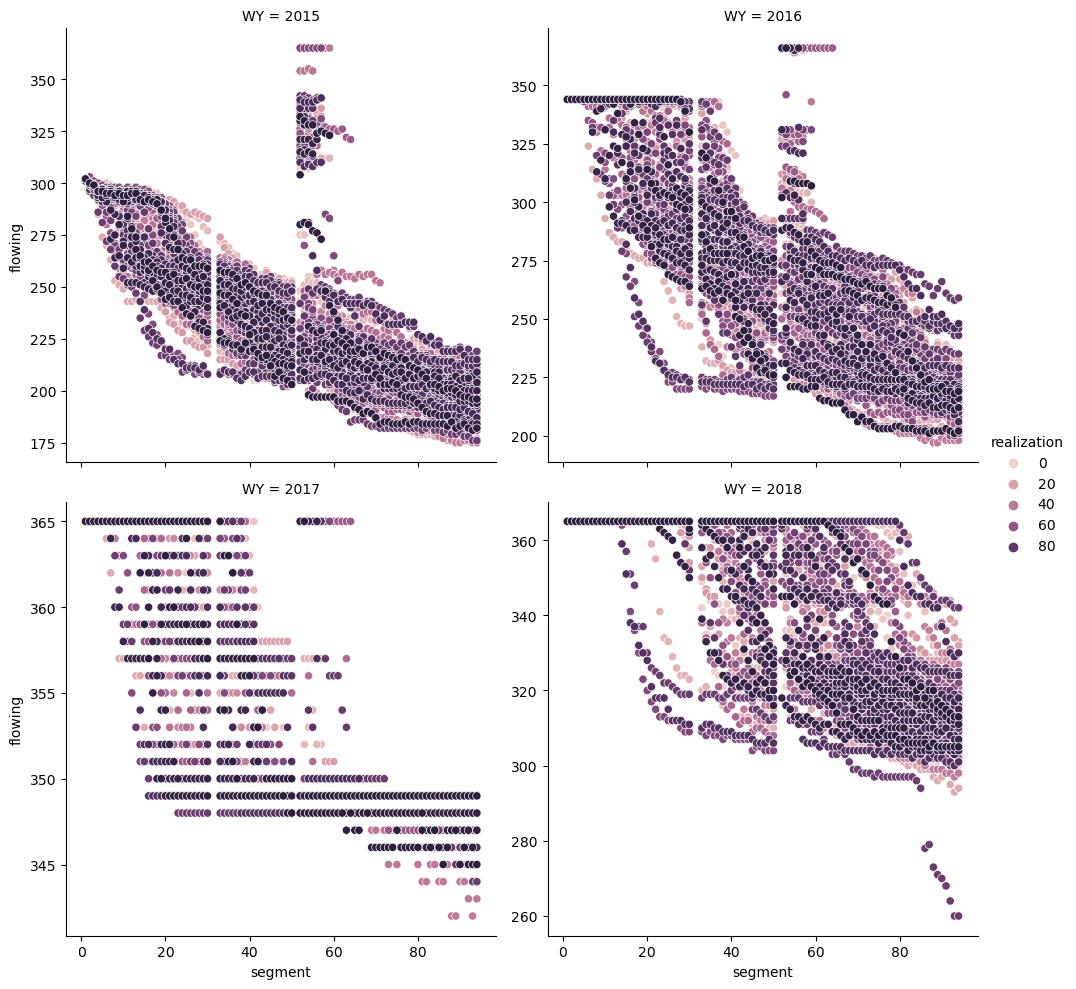

In [681]:
# need to see why water could be leaving the lake in a few scenarios
g = sns.relplot(sfr_yr_sum_all, x='segment',y='flowing', col='WY', col_wrap=2, hue='realization', #color='gray', 
           facet_kws={'sharey': False, 'sharex': True})



In [737]:
# check to see if lake is providing flow when it shouldn't
t = 10
model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))

lak_out = read_gage(join(model_ws, 'MF_lak.go'))

sfrdf = clean_sfr_df(model_ws, np.array([31, 32]))

In [768]:
np.log10((180*0.3048**3)*86400)

5.643831135584888

Index(['layer', 'row', 'column', 'segment', 'reach', 'Qin', 'Qaquifer', 'Qout',
       'Qovr', 'Qprecip', 'Qet', 'stage', 'depth', 'width', 'Cond', 'gradient',
       'strtop_all', 'k', 'i', 'j', 'rchlen', 'strtop', 'facies', 'color',
       'Total distance (m)', 'month', 'WY', 'flowing', 'Qin_cfs', 'Qout_cfs',
       'Qaquifer_cfs', 'Qrech', 'Qbase', 'gaining', 'losing', 'connected'],
      dtype='object')

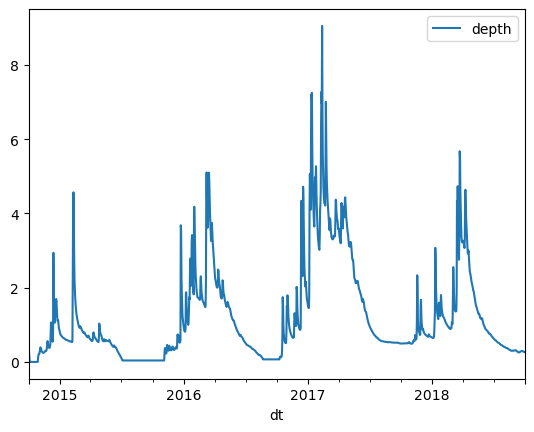

In [775]:
# streamflow is never 0, always some outflow from the lake
sfrdf[sfrdf.segment==52].plot(y='depth')
# plt.yscale('log')
sfrdf.columns

In [749]:
# the lake should have no outflow in all summers, but there is always some stage which might be causing the outflow to
# persist when it should be stopping
# the volume is zero in summer although the stage is not, gw inflow is zero in 2015 summer but not the rest
# the summer is actually when lake error is zero supposedly
lak_out['Stage(H)']['2015-1-1':'2015-10-1'].min()

2.9158723

<AxesSubplot: xlabel='dt'>

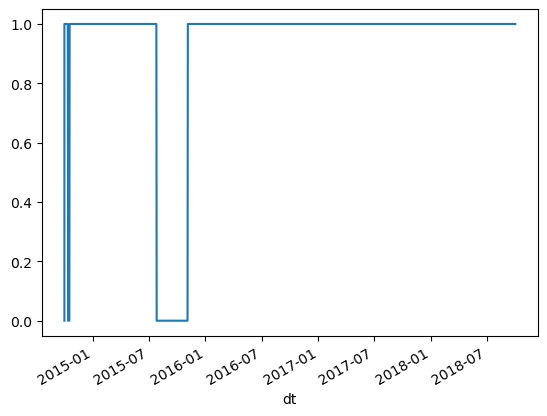

In [759]:
np.sign(lak_out['GW-Inflw']).plot()
# plt.yscale('log')
# lak_out

In [746]:
# segment 51 has strtop of 2.84, minimum summer stage is 2.915873
sfrdf[sfrdf.segment==51].strtop

dt
2014-10-01    2.841252
2014-10-02    2.841252
2014-10-03    2.841252
2014-10-04    2.841252
2014-10-05    2.841252
                ...   
2018-09-26    2.841252
2018-09-27    2.841252
2018-09-28    2.841252
2018-09-29    2.841252
2018-09-30    2.841252
Name: strtop, Length: 1461, dtype: float64

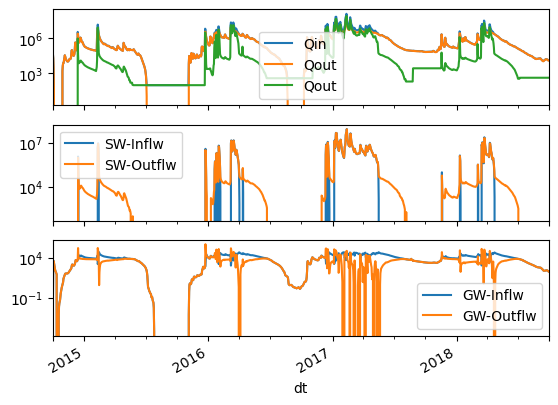

In [738]:
fig,ax = plt.subplots(3,1, sharex=True)
# lak_out.plot(y=['Stage(H)'], ax = ax[0]) 
# lak_out.columns # GW-Inflw, GW-Outflw, SW-Inflw, SW-Outflw
lak_out.plot(y=['GW-Inflw', 'GW-Outflw'], ax=ax[2]) # there is gw inflow
lak_out.plot(y=['SW-Inflw', 'SW-Outflw'], ax=ax[1]) # there is sw inflow
ax[1].set_yscale('log')
ax[2].set_yscale('log')

sfrdf[sfrdf.segment==52].plot(y='Qin',ax=ax[0])
sfrdf[sfrdf.segment==50].plot(y='Qout',ax=ax[0])
sfrdf[sfrdf.segment==51].plot(y='Qout',ax=ax[0])

ax[0].set_yscale('log')

In [470]:
# import seaborn as sns

# g = sns.relplot(sfrdf_all, x='num_coarse',y='Qbase', col= 'month', row='WY', color='gray', 
#            facet_kws={'sharey': False, 'sharex': True})



In [487]:
from sklearn import datasets, linear_model


In [541]:
# statistics used by Maples et al 2020, sensitivity of heterogeneity
from scipy.stats import pearsonr, spearmanr, kendalltau
pearsonr(df_plt['num_coarse'], df_plt['Qbase'])
spearmanr(df_plt['num_coarse'], df_plt['Qbase'])
kendalltau(df_plt['num_coarse'], df_plt['Qbase'])

SignificanceResult(statistic=0.39095515271357156, pvalue=1.1696165403211043e-08)

Text(0.85, 0.85, '$r^2$: 0.25')

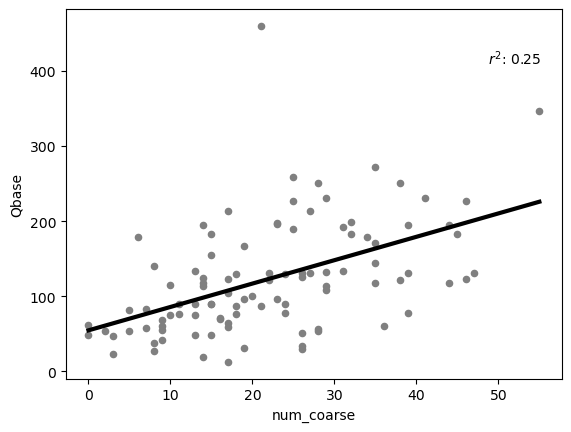

In [552]:
# exampel regression
plt_month = sfrdf_all[sfrdf_all.month==1]
df_plt = plt_month[plt_month.WY==2017]
ax = df_plt.plot(x='num_coarse',y='Qbase', kind='scatter', color='gray')

regr = linear_model.LinearRegression()
regr.fit(df_plt[['num_coarse']].values, df_plt[['Qbase']].values)
x_range = np.array([[df_plt.num_coarse.min()], [df_plt.num_coarse.max()]])
ax.plot(x_range, regr.predict(x_range), color='black', linewidth=3)
r2_val = r2_score(df_plt[['Qbase']], regr.predict(df_plt[['num_coarse']].values))
ax.annotate('$r^2$: '+ str(np.round(r2_val,3)), (0.85,0.85), xycoords='axes fraction')

In [564]:
def corr_plt_seep(name, ylabel):
    """ name is Qbase or Qrech"""
    fig,ax = plt.subplots(4,4, figsize=(12,8), sharex=True, sharey=False)
    # plot of number of connected days across realizations

        # plot across 3 month blocks in columns
    for mn, mon in enumerate(sfrdf_all.month.unique()):
        plt_month = sfrdf_all[sfrdf_all.month==mon]
        # plot across years in rows
        for yn, wy in enumerate(plt_month.WY.unique()):
            ax_n = ax[yn, mn]
            df_plt = plt_month[plt_month.WY==wy]
            df_plt.plot(x='num_coarse',y=name, kind='scatter', color='gray', ax = ax_n)
            # linear, regression
#             sns.regplot(x='num_coarse', y=name,data=df_plt,ci=False,ax=ax_n, label='Linear Model', scatter=False)
            regr = linear_model.LinearRegression()
            regr.fit(df_plt[['num_coarse']].values, df_plt[[name]].values)
            x_range = np.array([[df_plt.num_coarse.min()], [df_plt.num_coarse.max()]])
            ax_n.plot(x_range, regr.predict(x_range), color='black', linewidth=3)
            r2_val = r2_score(df_plt[[name]], regr.predict(df_plt[['num_coarse']].values))
            ax_n.annotate('$r^2$: '+ str(np.round(r2_val,3)), (0.1,0.8), xycoords='axes fraction')
            # plot clean up
            ax_n.set_ylabel('')
            ax_n.set_xlabel('')

    for yn, wy in enumerate(plt_month.WY.unique()):
        ax_n = ax[yn, 0]
        ax_n.set_ylabel(str(wy))
    for mn, mon in enumerate(sfrdf_all.month.unique()):
        ax_n = ax[0, mn]
        ax_n.set_title(str(mon))
    fig.text(-0.01, 0.4, 'Mean Seasonal '+ylabel+' ($m^3/day$)', rotation=90)
    fig.text(0.4, -0.01, 'Number of Coarse Stream Segments')

    fig.tight_layout()

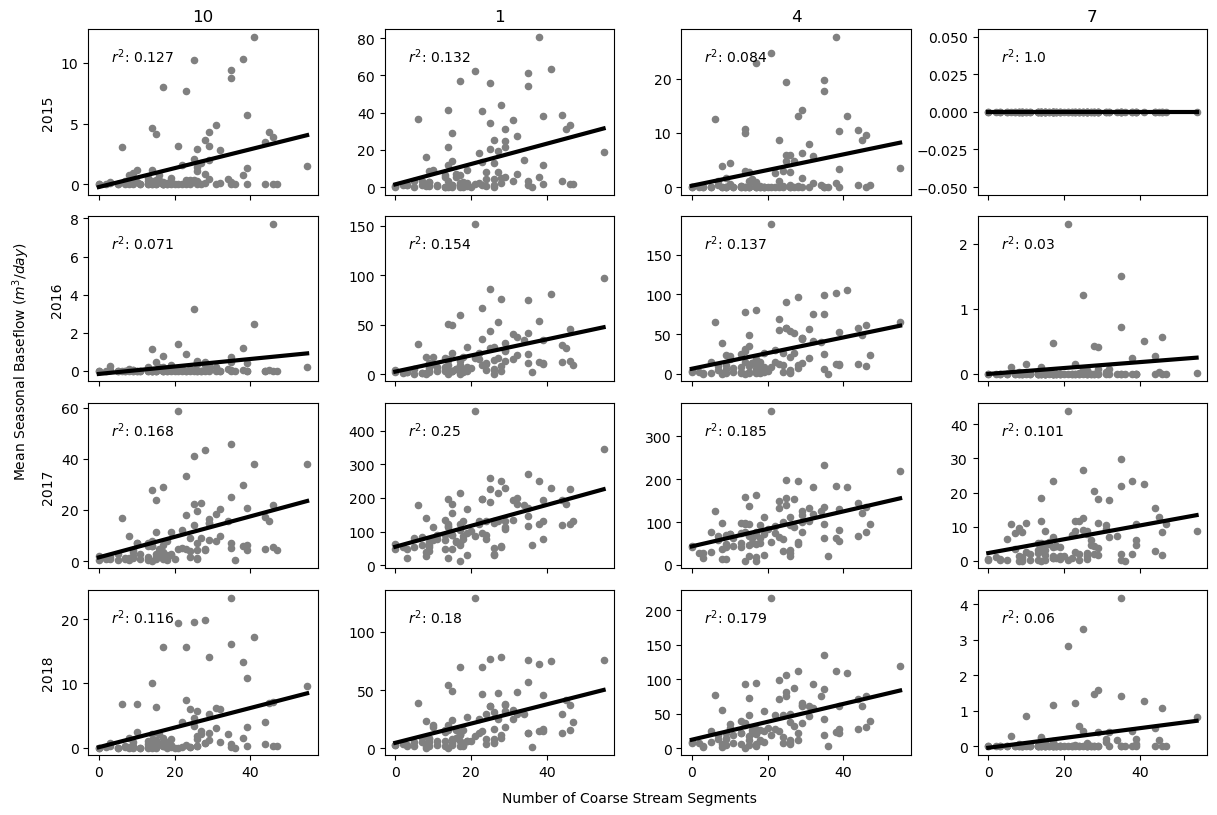

In [562]:
corr_plt_seep('Qbase', 'Baseflow')

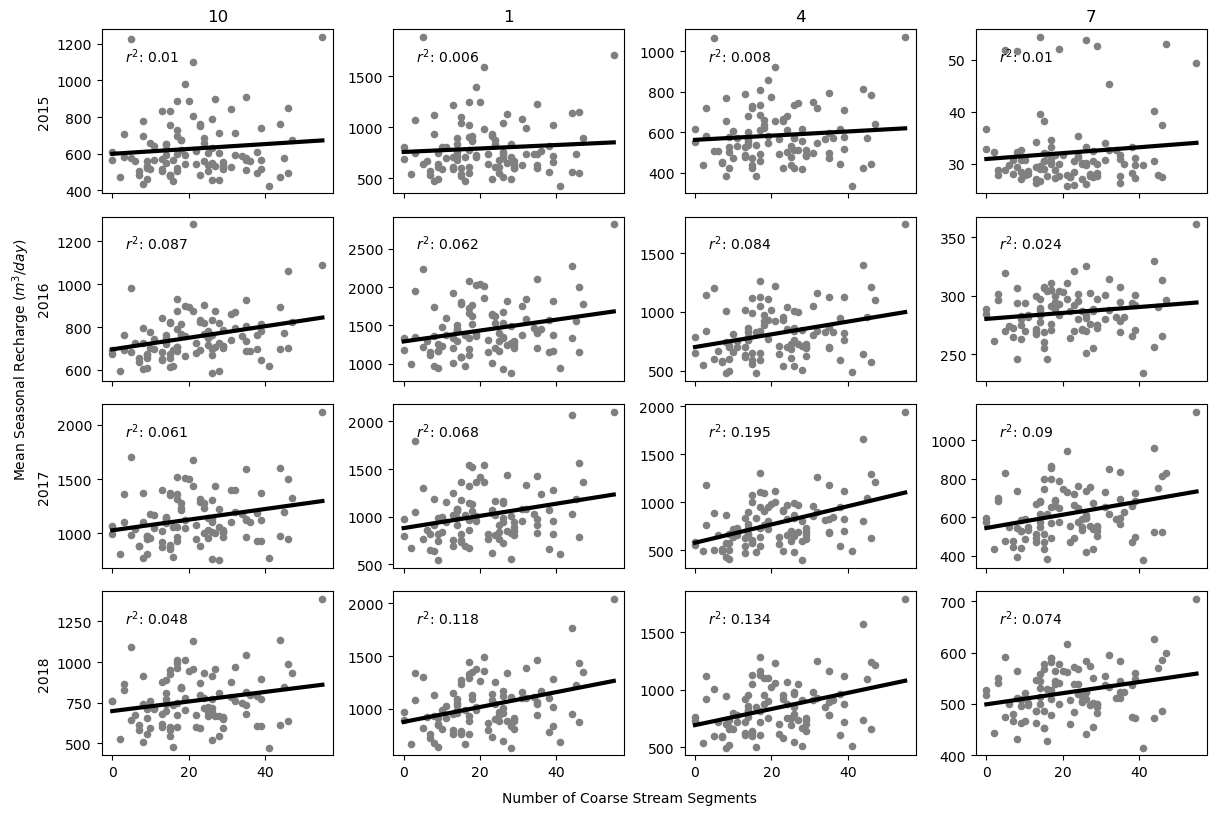

In [565]:
corr_plt_seep('Qrech', 'Recharge')

In [569]:
sfrdf_all

,layer,row,column,segment,reach,Qin,Qaquifer,Qout,Qovr,Qprecip,...,Qaquifer_cfs,Qrech,Qbase,gaining,losing,connected,realization,num_coarse,month,WY
dt,,,,,,,,,,,,,,,,,,,,,
2014-10-01,1.989362,43.159574,40.87234,47.5,1.0,1.787147e+05,503.779634,1.782031e+05,0.0,0.0,...,0.205912,503.959385,0.179751,0.0,0.989593,0.404949,0.0,17.0,10,2015
2015-01-01,1.989362,43.159574,40.87234,47.5,1.0,5.799498e+05,543.665954,5.794184e+05,0.0,0.0,...,0.222215,550.128545,6.462591,0.0,0.920922,0.985934,0.0,17.0,1,2015
2015-04-01,1.989362,43.159574,40.87234,47.5,1.0,8.598328e+04,458.316653,8.553537e+04,0.0,0.0,...,0.187330,458.872679,0.556026,0.0,0.968553,0.916647,0.0,17.0,4,2015
2015-07-01,1.989362,43.159574,40.87234,47.5,1.0,2.171994e+02,30.365283,1.876722e+02,0.0,0.0,...,0.012411,30.365283,0.000000,0.0,1.000000,0.012142,0.0,17.0,7,2015
2015-10-01,1.989362,43.159574,40.87234,47.5,1.0,1.960193e+05,690.233557,1.953129e+05,0.0,0.0,...,0.282122,690.233557,0.000000,0.0,0.996994,0.146970,0.0,17.0,10,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-01,1.989362,43.159574,40.87234,47.5,1.0,1.100274e+05,540.510658,1.095004e+05,0.0,0.0,...,0.220925,541.919961,1.409302,0.0,0.961725,0.874653,99.0,8.0,7,2017
2017-10-01,1.989362,43.159574,40.87234,47.5,1.0,1.923584e+05,744.961752,1.916085e+05,0.0,0.0,...,0.304492,744.963702,0.001950,0.0,0.981846,0.789431,99.0,8.0,10,2018
2018-01-01,1.989362,43.159574,40.87234,47.5,1.0,2.192296e+06,934.972013,2.191098e+06,0.0,0.0,...,0.382155,935.405676,0.433663,0.0,0.965366,0.952955,99.0,8.0,1,2018


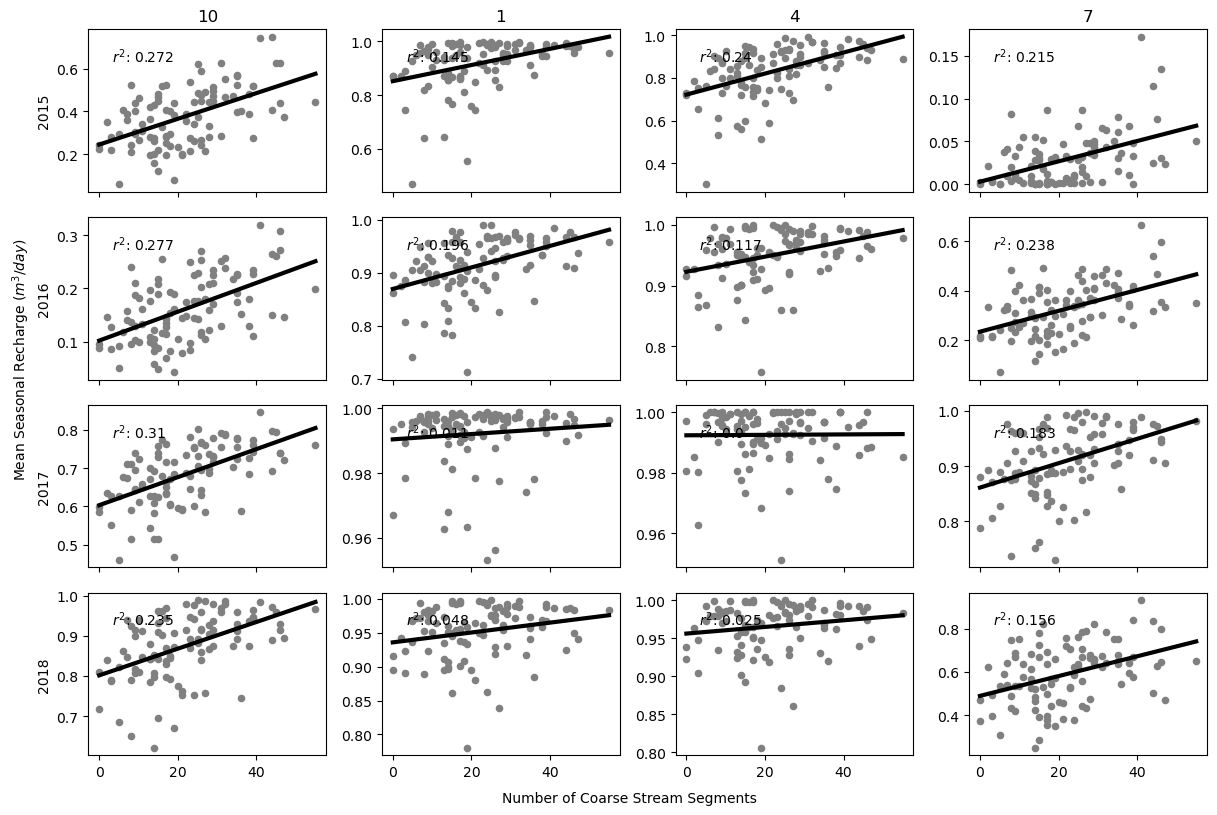

In [567]:
# when it comes to the dry season
# the connected days show more correlation to the coarse segments
corr_plt_seep('connected', 'Connected Fraction')